In [16]:
import numpy as np
from scipy.optimize import curve_fit
from scipy.signal import argrelextrema
from scipy.interpolate import interp1d

from matplotlib import pyplot as plt
import reciprocalspaceship as rs
import gemmi

## data loading

In [24]:
def cut_res(df, h_res, l_res):
    ds.compute_dHKL(inplace=True)
    df = df.loc[(df['dHKL'] >= h_res) & (df['dHKL'] <= l_res)]
    return df

In [17]:
base_path = '/Users/tjlane/Desktop/PL\ workshop/DEDs-svd/'

timepoints = {
         3.0 : './3ps_LIGHT_staraniso_unityDO_Rfree_mkFoFo.mtz',
       300.0 : './300ps_LIGHT_staraniso_unityDORfree_mkFoFo.mtz',
      1000.0 : './1ns_LIGHT_staraniso_unity_mkFoFo.mtz',
      3000.0 : './3ns_unity_LIGHT_staraniso_darkrefinedmodel-merged-aniso_mkFoFo.mtz',
     10000.0 : './10ns_light_new_EDITED-SP_celledited_staraniso_mkFoFo.mtz',
     30000.0 : './30ns_LIGHT_staraniso_unityDORfree_mkFoFo.mtz',
   1000000.0 : './1us_LIGHT_staraniso_unity_DORfree_mkFoFo.mtz',
  10000000.0 : './10us_LIGHT_staraniso_unity_DORfree_mkFoFo.mtz',
 100000000.0 : './100us_LIGHT_staraniso_unity_DORfree_mkFoFo.mtz' ,
}

for k in timepoints.keys():
    timepoints[k] = base_path + timepoints[k]

In [38]:
def standardize(map):
    return (map - map.mean()) / map.std()

# load all Fs and sigFs into one big rs table
tps = sorted(timepoints.keys())
maps = []

for tp in tps:

    ds = rs.read_mtz(timepoints[tp]) 
    ds.compute_dHKL(inplace=True)
    print( np.min(ds['dHKL']), np.max(ds['dHKL']) )
    ds = cut_res(ds, 2.50, 25.0)

    ds['DF'] = ds.to_structurefactor('KFOFOWT', 'PHIKFOFOWT')
    grid = ds.to_reciprocal_grid('DF', sample_rate=1.0)
    map = np.real( np.fft.fftn(grid) )
    #map = standardize(map)
    maps.append(map.flatten())

maps = np.array(maps)
print(maps.shape)

2.2000265 24.612986
2.2000265 24.612986
2.2005873 24.612986
2.277084 24.612986
2.4000225 24.612986
2.5000052 24.612986
2.4000225 24.612986
2.4000225 24.612986
2.2000916 24.612986
(9, 103680)


## and try SVD

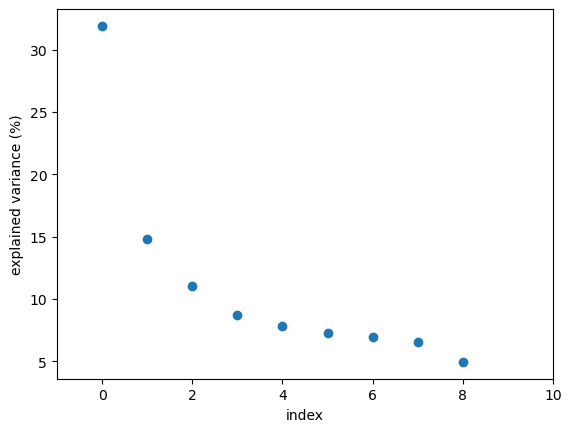

In [39]:
U, S, Vh = np.linalg.svd(maps, full_matrices=False)

plt.figure()
plt.plot(np.square(S) / np.sum(np.square(S)) * 100.0, 'o')
plt.xlabel('index')
plt.ylabel('explained variance (%)')
plt.xlim([-1, 10])
plt.show()

(30, 48, 72) (9, 9) (9, 103680)


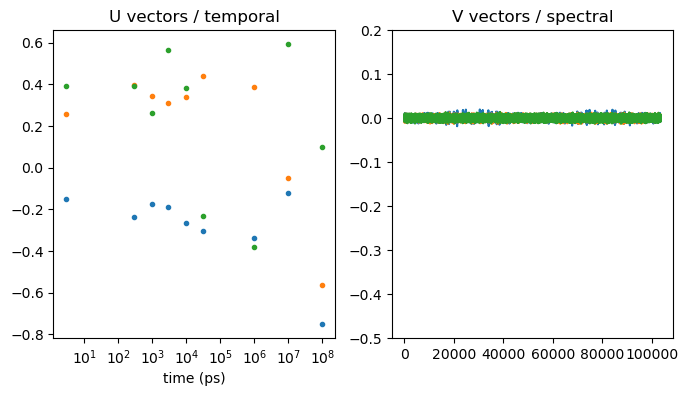

In [42]:
n = 3 # number of components
print(map.shape, U.shape, Vh.shape)

plt.figure(figsize=(8,4))

axL = plt.subplot(121)
axL.plot(np.array(tps), U[:,:n] + 0.07 * np.arange(n)[None,:], '.')
plt.title('U vectors / temporal')
plt.xlabel('time (ps)')
#plt.ylim([-0.2, 0.4])
plt.xscale('symlog')
#plt.xlim([1000,1.5e6])

axR = plt.subplot(122)
axR.plot(Vh[:n,:].T)
plt.title('V vectors / spectral')
#plt.xlabel('wavelengths (nm)')
plt.ylim([-0.5, 0.2])

plt.show()

/var/folders/s9/bht_sc9n7ys6m0q3h_3htntc0000gn/T/ipykernel_88763/1457635051.py:7: RuntimeWarning: overflow encountered in exp
  expntl = lambda t,a,b: a * np.exp(-b*t)


[-2.18186828e-01 -1.23026092e-08]


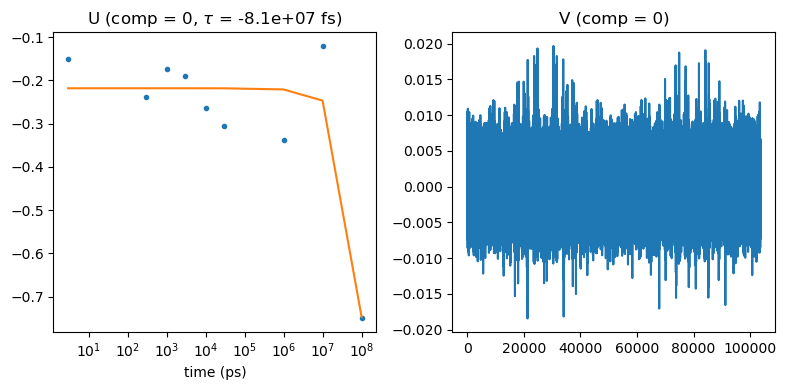

In [41]:
component = 0
sign      = 1

x = np.array(tps)
y = sign * U[:, component]

expntl = lambda t,a,b: a * np.exp(-b*t)
p_opt, _ = curve_fit(expntl,  x,  y,  p0=(0.1, 1e-3))
print(p_opt)

plt.figure(figsize=(8,4))

axL = plt.subplot(121)
axL.plot(x, sign * U[:,component], '.')
axL.plot(x, expntl(x, *p_opt))

plt.title(r'U (comp = %d, $\tau$ = %.1e fs)' % (component, 1.0/p_opt[1]))
axL.set_xlabel('time (ps)')

#axL.set_xlim([1e2, 2e6])
#axL.set_ylim([-0.025, 0.12])
axL.set_xscale('symlog')

axR = plt.subplot(122)
axR.plot(sign * Vh[component,:].T)
plt.title('V (comp = %d)' % component)
#axR.set_xlabel('wavelengths (nm)')
#axR.set_ylim([-0.05, 0.15])

plt.tight_layout()
#plt.savefig('figures/%.1f_mW-%dth_comp.pdf' % (power_to_analyze, component))
plt.show()